In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy as sc
import scipy
import warnings
from tqdm.notebook import tqdm
import pickle as pkl
from matplotlib.patches import Polygon

import matplotlib as mpl
import seaborn as sns

In [2]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

## Reading in Data

In [3]:
###use Yutong's decontamation v2 

In [ ]:
#adata = sc.read_csv('../../../../decont_mat/decont_mat_after_v1.csv').T
adata = sc.read_csv('../../../../decont_mat/decont_mat_after_v2.csv').T

In [ ]:
adata.obs

In [ ]:
adata.obs['batch'] = adata.obs.index.str[-1:]

In [ ]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)

adata.obs['log_counts'] = np.log(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [ ]:
adata.obs['barcode'] = adata.obs.index.str[-18:-2]

In [ ]:
adata.var_names_make_unique()

In [ ]:
#sc.pl.highest_expr_genes(adata, n_top=100) 

In [ ]:
mito_genes_mouse=[name for name in adata.var_names if name.startswith(('mm10_mt-'))]
                                                              
mito_genes_human=[name for name in adata.var_names if name.startswith(('hg19_MT-'))] 

adata.obs['percent_mito_mouse'] = np.sum(adata[:, mito_genes_mouse].X, axis=1) / np.sum(adata.X, axis=1)*100

adata.obs['percent_mito_human'] = np.sum(adata[:, mito_genes_human].X, axis=1) / np.sum(adata.X, axis=1)*100

In [ ]:
#sc.pp.filter_cells(adata, min_counts = 500)

In [ ]:
#sc.pp.filter_cells(adata, min_genes = 100)

In [ ]:
#sc.pp.filter_genes(adata, min_cells=1)

In [ ]:
#adata = adata[adata.obs['n_counts'] < 10000, :]

In [ ]:
#adata = adata[adata.obs['percent_mito_mouse'] < 1, :]

In [ ]:
adata.obs.batch.value_counts()

In [ ]:
####call cell species

mouse_genes=[name for name in adata.var_names if name.startswith('mm10_')]

#mouse_genes=[name for name in adata.var_names if name.startswith('mm10___')]
#human_genes=[name for name in adata.var_names if name.startswith('GRCh38_')]

human_genes=[name for name in adata.var_names if name.startswith('hg19_')]


adata.obs['mouse_counts'] = np.sum(adata[:, mouse_genes].X, axis=1)
adata.obs['human_counts'] = np.sum(adata[:, human_genes].X, axis=1)

In [ ]:
cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])

np.seterr(divide = 'ignore') 
adata.obs['ratio'] = np.log10(np.true_divide(adata.obs['mouse_counts'], adata.obs['human_counts']))


def cell_call(counts):
        if counts['ratio'] > 0.66:
                return 'M'
        elif counts['ratio'] < -0.66:
                return 'H'
        else:
                return 'C'

         
adata.obs['cell_call']=adata.obs.apply(lambda counts: cell_call(counts), axis=1)



In [ ]:
adata

In [ ]:
contam = pd.read_csv('../../../../contamination_analysis/est_contam_before.csv',
                    index_col=0)
# contam = pd.read_csv('../../../../contamination_analysis/est_contam_after.csv',
#                     index_col=0)

In [ ]:
contam.cell_iden.replace({'\.':'-'}, regex=True)

In [ ]:
contam.columns = ['cell_iden','CellType','contam_init']
contam.index=contam.cell_iden

In [ ]:
adata.obs['contam_init']=contam.contam_init

# Fitler out human cells and mixed species

In [ ]:


adata_m = adata[adata.obs.cell_call == 'M']

In [ ]:
adata_m.raw = adata_m

In [ ]:
##remove human transcripts from matrix 

#adata_m = adata_m[:, adata_m.var_names.str.startswith('mm10_')]

In [ ]:
adata_m.raw = sc.pp.log1p(adata_m, copy=True)

In [ ]:
sc.pp.normalize_per_cell(adata_m, counts_per_cell_after=1e4)

In [ ]:
filter_result = sc.pp.filter_genes_dispersion(
    adata_m.X,
#      n_top_genes=2000
    min_mean=0.35,
    max_mean=7,
    min_disp=1,

                                            ) 


####L20C1 parameters 

sc.pl.filter_genes_dispersion(filter_result)

In [ ]:
genes = pd.DataFrame.from_records(filter_result)

In [ ]:
genes['name'] = adata.var_names.to_series().reset_index()['index']

In [ ]:
plt.rcParams['figure.figsize'] = 5,5

sns.scatterplot(data=genes,
               x='means',
               y='dispersions_norm',
               color='grey',
                s=10,
                linewidth=0
               )

sns.scatterplot(data=genes[genes.eval("means < 7 & means >= 0.35 & dispersions_norm >= 1")],
               x='means',
               y='dispersions_norm',
               color='Black',
               s=10,
                linewidth=0
               )


sns.scatterplot(data=genes[genes.name.str.startswith('mm10_Smim20')],
               x='means',
               y='dispersions_norm',
               color='Red',
               s=30,
                linewidth=0
               )

In [ ]:
genes[genes.name == 'mm10_Smim20']

In [ ]:
adata_m = adata_m[:, filter_result.gene_subset]

In [ ]:
sc.pp.log1p(adata_m)

In [ ]:
#Regress out unwanted sources of variation
sc.pp.regress_out(adata_m, ['n_counts',
#                           'percent_mito_human',
                           'percent_mito_mouse',
#                          'contam_init'
                         ])

In [ ]:
sc.pp.scale(adata_m, max_value=10)

In [ ]:
sc.tl.pca(adata_m,
          svd_solver='arpack'
         )

In [ ]:
sc.tl.tsne(adata_m,
           n_pcs=13,
        #    early_exaggeration=10
          )
sc.tl.embedding_density(adata_m, basis='tsne')

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]

sc.pl.tsne(adata_m,
           color=['mm10_Smim20','mm10_Itgam'],
           ncols=1,
           palette='tab10',
           size=50
          )

In [ ]:
sc.pp.neighbors(adata_m, 
                n_neighbors=10,
                n_pcs=15)

In [ ]:
sc.tl.leiden(adata_m, resolution=0.6)

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]



sc.pl.tsne(adata_m,
          color=['batch',
                ]
           ,
           ncols=2,
           palette='tab20c_r',
            size=500
          )

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]



sc.pl.tsne(adata_m,
          color=['leiden',
                ]
           ,
           ncols=2,
           palette='tab20c_r',
           color_map='viridis',
            size=1000
          )

In [ ]:
sc.tl.umap(adata_m,          
             min_dist=.5,
             spread=5,
             alpha=5,
            )
#sc.tl.embedding_density(adata_m, basis='umap')

In [ ]:
cmap = mpl.colors.LinearSegmentedColormap.from_list(name='gene_cmap',
                                                    colors=['lightgrey',
                                                            'thistle',
                                                            'red',
                                                            'darkred'])

In [ ]:
plt.rcParams['figure.figsize'] = [32, 32]
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30

sc.pl.umap(adata_m, 
           color=['leiden',
           'batch'],
           ncols=1,
           palette='tab20c_r',
           color_map=cmap,
      #     legend_loc='on data',
           size=2000)

In [ ]:
sc.tl.rank_genes_groups(adata_m,groupby='leiden')

In [ ]:
sc.pl.rank_genes_groups(
                        adata_m,
                       fontsize=40,
                       ncols=2
                        )

In [ ]:
cell_type_df=pd.DataFrame(adata_m.obs['leiden'])

def label (row):
   if row['leiden'] == '0':
      return 'mc38'
   if row['leiden'] =='1':
      return 'Hepatocyte'
   if row['leiden'] == '2':
      return 'Monocyte'
   if row['leiden'] == '3':
      return 'Hepatocyte'
   if row['leiden']  == '4':
      return 'mc38'
   if row['leiden'] == '5':
      return 'Hepatocyte'
   if row['leiden'] == '6':
      return 'MSC'
   if row['leiden'] == '7':
      return 'Lymphocyte'
   if row['leiden'] == '8':
      return 'Macrophage'
   if row['leiden'] == '9':
      return 'Kupffer'
   if row['leiden'] == '10': 
      return 'LSEC'
   if row['leiden'] == '11':    
      return 'mc38'
   if row['leiden'] == '12':    
      return 'mc38'



    
cell_type_df_ =  pd.DataFrame(cell_type_df.apply (lambda row: label(row), axis=1),)

cell_type_df_.columns=['CellType']

adata_m.obs['CellType']=cell_type_df_

In [ ]:
adata_m.uns['CellType_colors']=[
# '#d9d9d9',    #Hek293t   Grey
 '#fb8072', #Hepatocyte   Red
 '#fdb462', #Kupffer   Orange
 '#80b1d3', #LSEC   Blue
 '#bc80bd', #Lymphocyte   Purple 
 '#8dd3c7',#MSC    Cyan 
 '#ccebc5', #Macrophage   Light Green
 '#ffed6f',#mc38    Yellow
 '#8bca80'
]

In [ ]:
adata.obs

In [ ]:
plt.rcParams['figure.figsize'] = [32, 32]
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
sc.pl.tsne(adata_m,
          color=['mm10_Elmo1'],
    
           ncols=1,
           size=1500
          )

In [ ]:
plt.rcParams['figure.figsize'] = [32, 32]
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
sc.pl.umap(adata_m,
          color=['batch'],
           color_map='viridis',
    
           ncols=1,
           size=1000
          )

In [ ]:
adata.obs.columns

In [ ]:
sc.tl.rank_genes_groups(adata_m,
                        groupby='CellType',
                        method='wilcoxon')

sc.tl.filter_rank_genes_groups(adata_m,
                              min_fold_change=1.5)

In [ ]:
plt.rcParams['figure.figsize'] = 40,40

sc.pl.rank_genes_groups_heatmap(adata_m[adata_m.obs.batch == '1'],
                                swap_axes=False,
                                key='rank_genes_groups_filtered',
                                n_genes=200,
                                 vmax=4,
                                 vmin=-1,
                                cmap=cmap,
                                dendrogram=True
                                
                               )

In [ ]:
#adata_m.write_h5ad('ProcessedLiver_AllBatches_mouse.h5ad')

In [ ]:
adata_m.obs

In [ ]:
sc.pl.violin(adata_m,
            keys='contam_init',
            groupby='CellType',
            s=50)

In [ ]:
adata_decon = adata_m[adata_m.obs.contam_init < 0.2]

In [ ]:
adata_decon

In [ ]:
adata_m.obs.contam_init.median()

In [ ]:
5626/6623

In [ ]:
adata_decon

In [ ]:
sc.tl.tsne(adata_decon,
           n_pcs=13,
        #    early_exaggeration=10
          )
sc.tl.embedding_density(adata_decon, basis='tsne')

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]



sc.pl.tsne(adata_decon,
          color=['CellType',''
                ]
           ,
           ncols=2,
          # palette='tab20c_r',
            size=500
          )

In [ ]:
sc.pp.neighbors(adata_decon, 
                n_neighbors=10,
                n_pcs=13)

In [ ]:
sc.tl.umap(adata_decon,          
             min_dist=.5,
             spread=5,
             alpha=5,
            )
sc.tl.embedding_density(adata_decon, basis='umap')

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]



sc.pl.umap(adata_decon,
          color=['CellType','umap_density'
                ]
           ,
           ncols=2,
          # palette='tab20c_r',
            size=500
          )

In [109]:
scores = pd.read_csv('/Users/derekbogdanoff/projects/XYZeq/covars.with.smooth.proximity.scores_2.csv',
               header=None,
               names=['index','sample','type1','type2','barcode','num_1','num_2','prox_1','prox_2','bool'],
               index_col=0,
                usecols=['index','prox_1','prox_2']
                     
                    )

In [110]:
scores.index = scores.index.str.replace(r'_', '.', regex=True)
scores.index = scores.index.str.replace(r'-', '.', regex=True)

In [111]:
adata_decon = adata_decon[adata_decon.obs.index.isin(scores.index.to_list())]
adata_decon.obs['prox_1']=scores['prox_1']
adata_decon.obs['prox_2']=scores['prox_2']

Trying to set attribute `.obs` of view, copying.


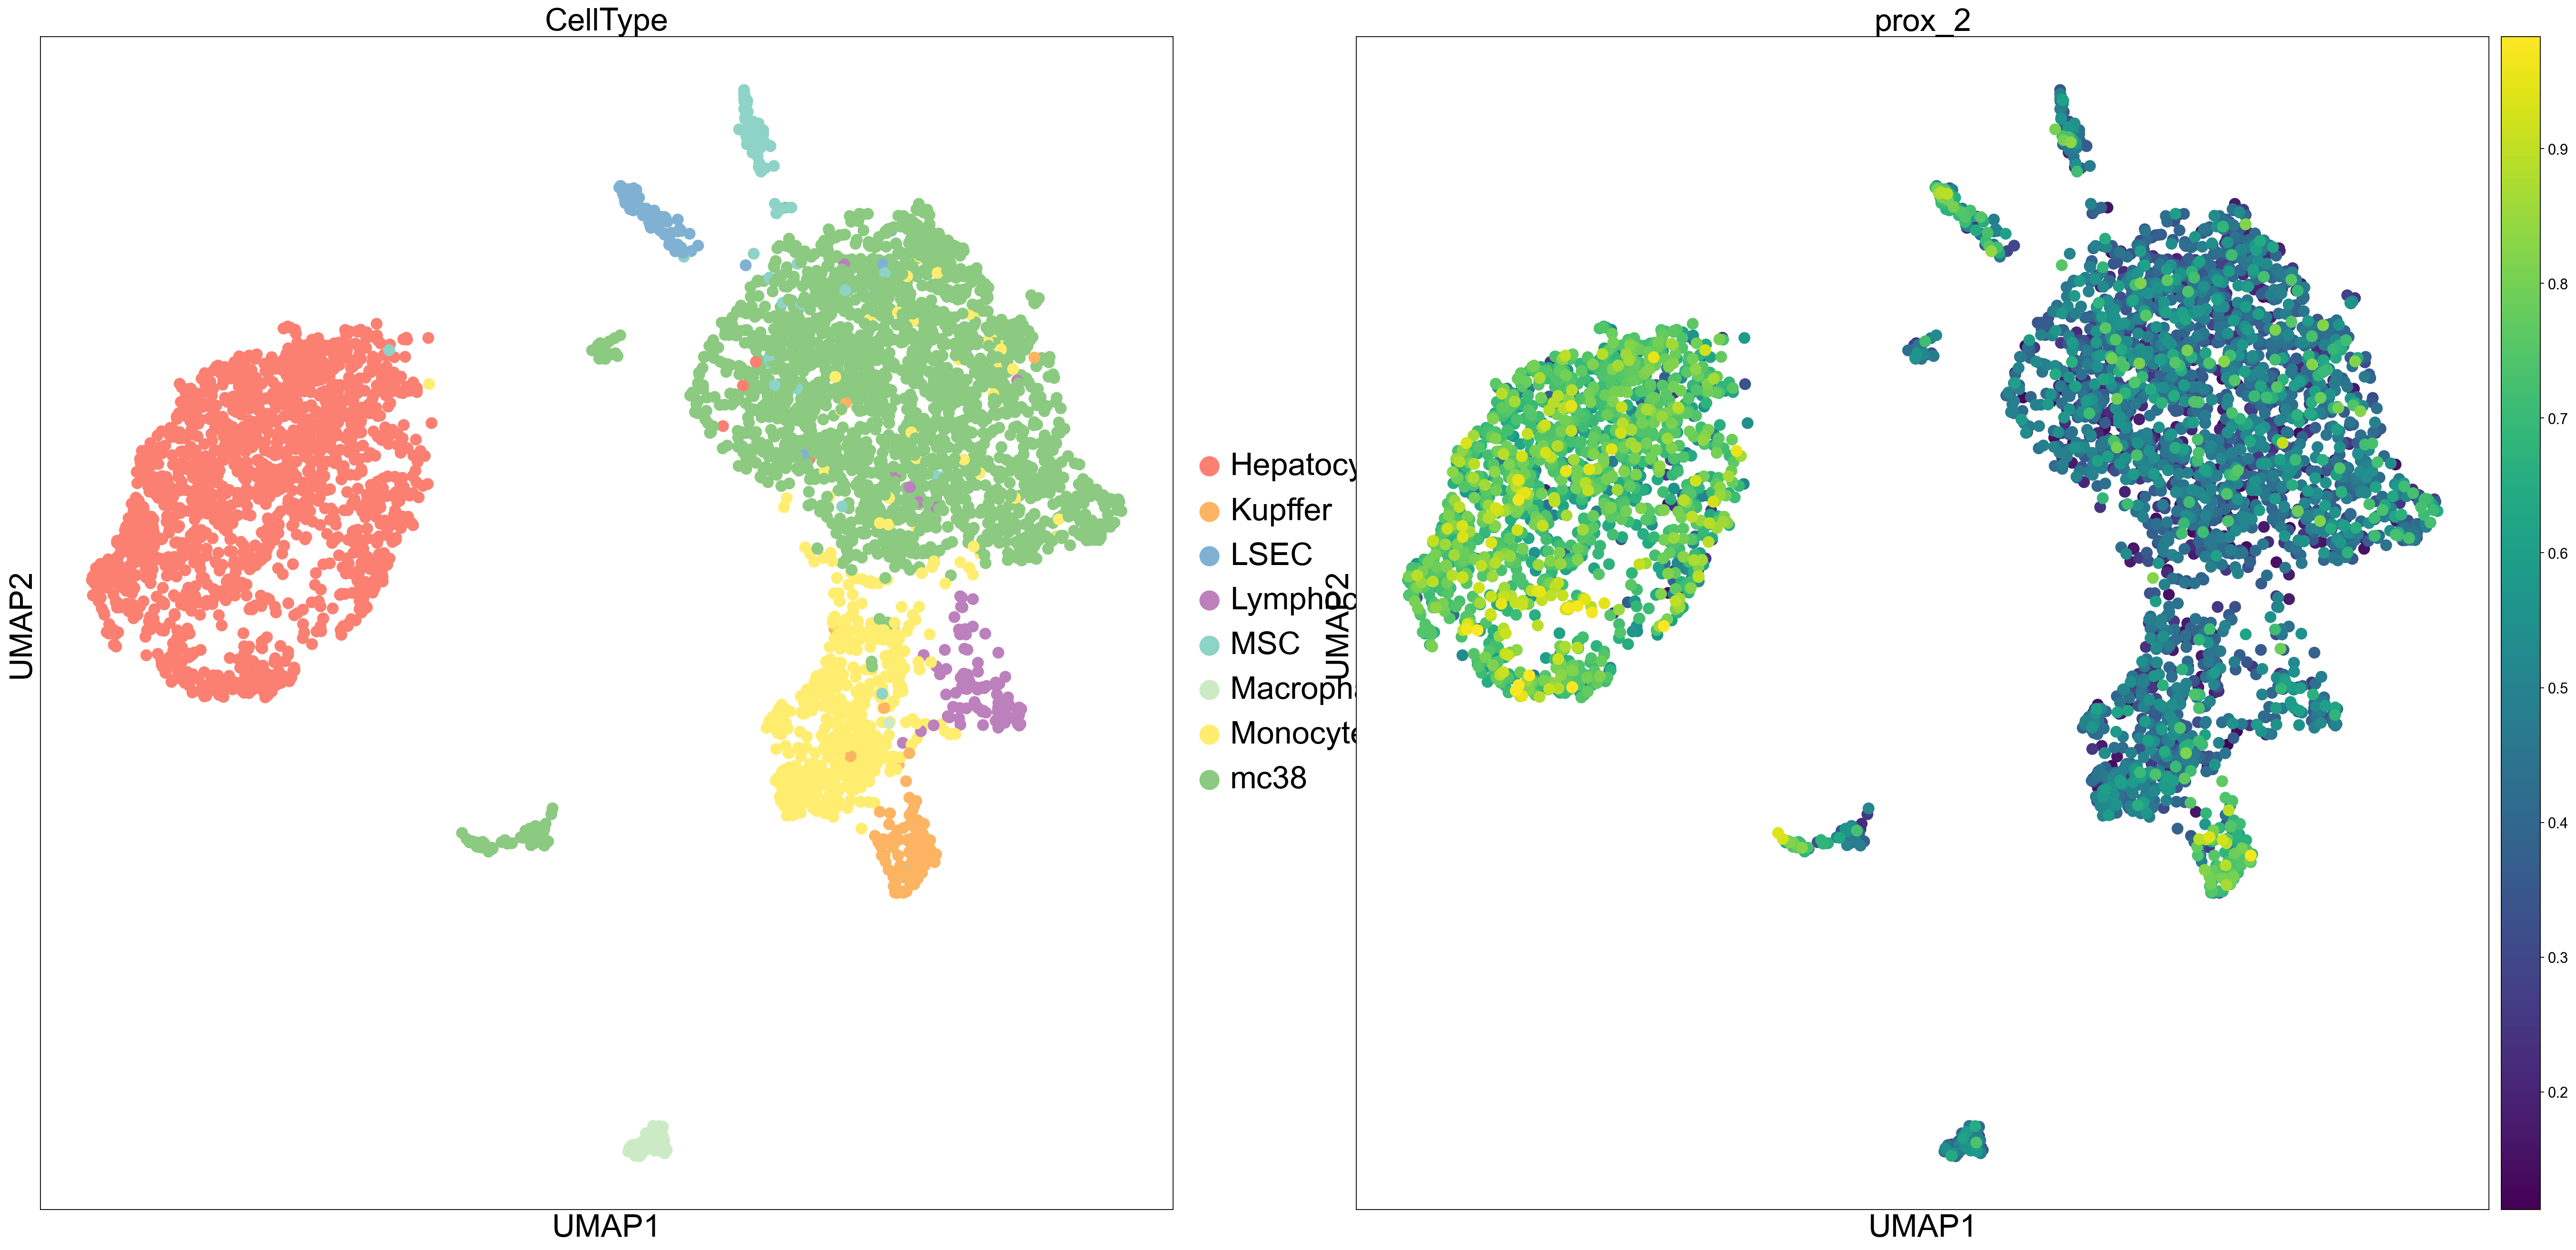

In [115]:
plt.rcParams['figure.figsize'] = [20, 20]



sc.pl.umap(adata_decon,
          color=['CellType','prox_2'
                ]
           ,
           ncols=2,
          # palette='tab20c_r',
            size=500
          )

In [116]:
adata_macro = adata_m[adata_m.obs.CellType == 'Monocyte']

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [117]:
adata_macro

View of AnnData object with n_obs × n_vars = 716 × 764
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'barcode', 'percent_mito_mouse', 'percent_mito_human', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'contam_init', 'tsne_density', 'leiden', 'CellType', '__is_in_cluster__', 'umap_density', 'prox_1', 'prox_2'
    var: 'mean', 'std'
    uns: 'log1p', 'pca', 'tsne_density_params', 'neighbors', 'leiden', 'batch_colors', 'leiden_colors', 'umap', 'rank_genes_groups', 'CellType_colors', 'rank_genes_groups_filtered', 'umap_density_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [128]:
sc.pp.neighbors(adata_m, n_neighbors=15, n_pcs=3)
sc.tl.draw_graph(adata_m)

computing neighbors
    using 'X_pca' with n_pcs = 3
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:40)


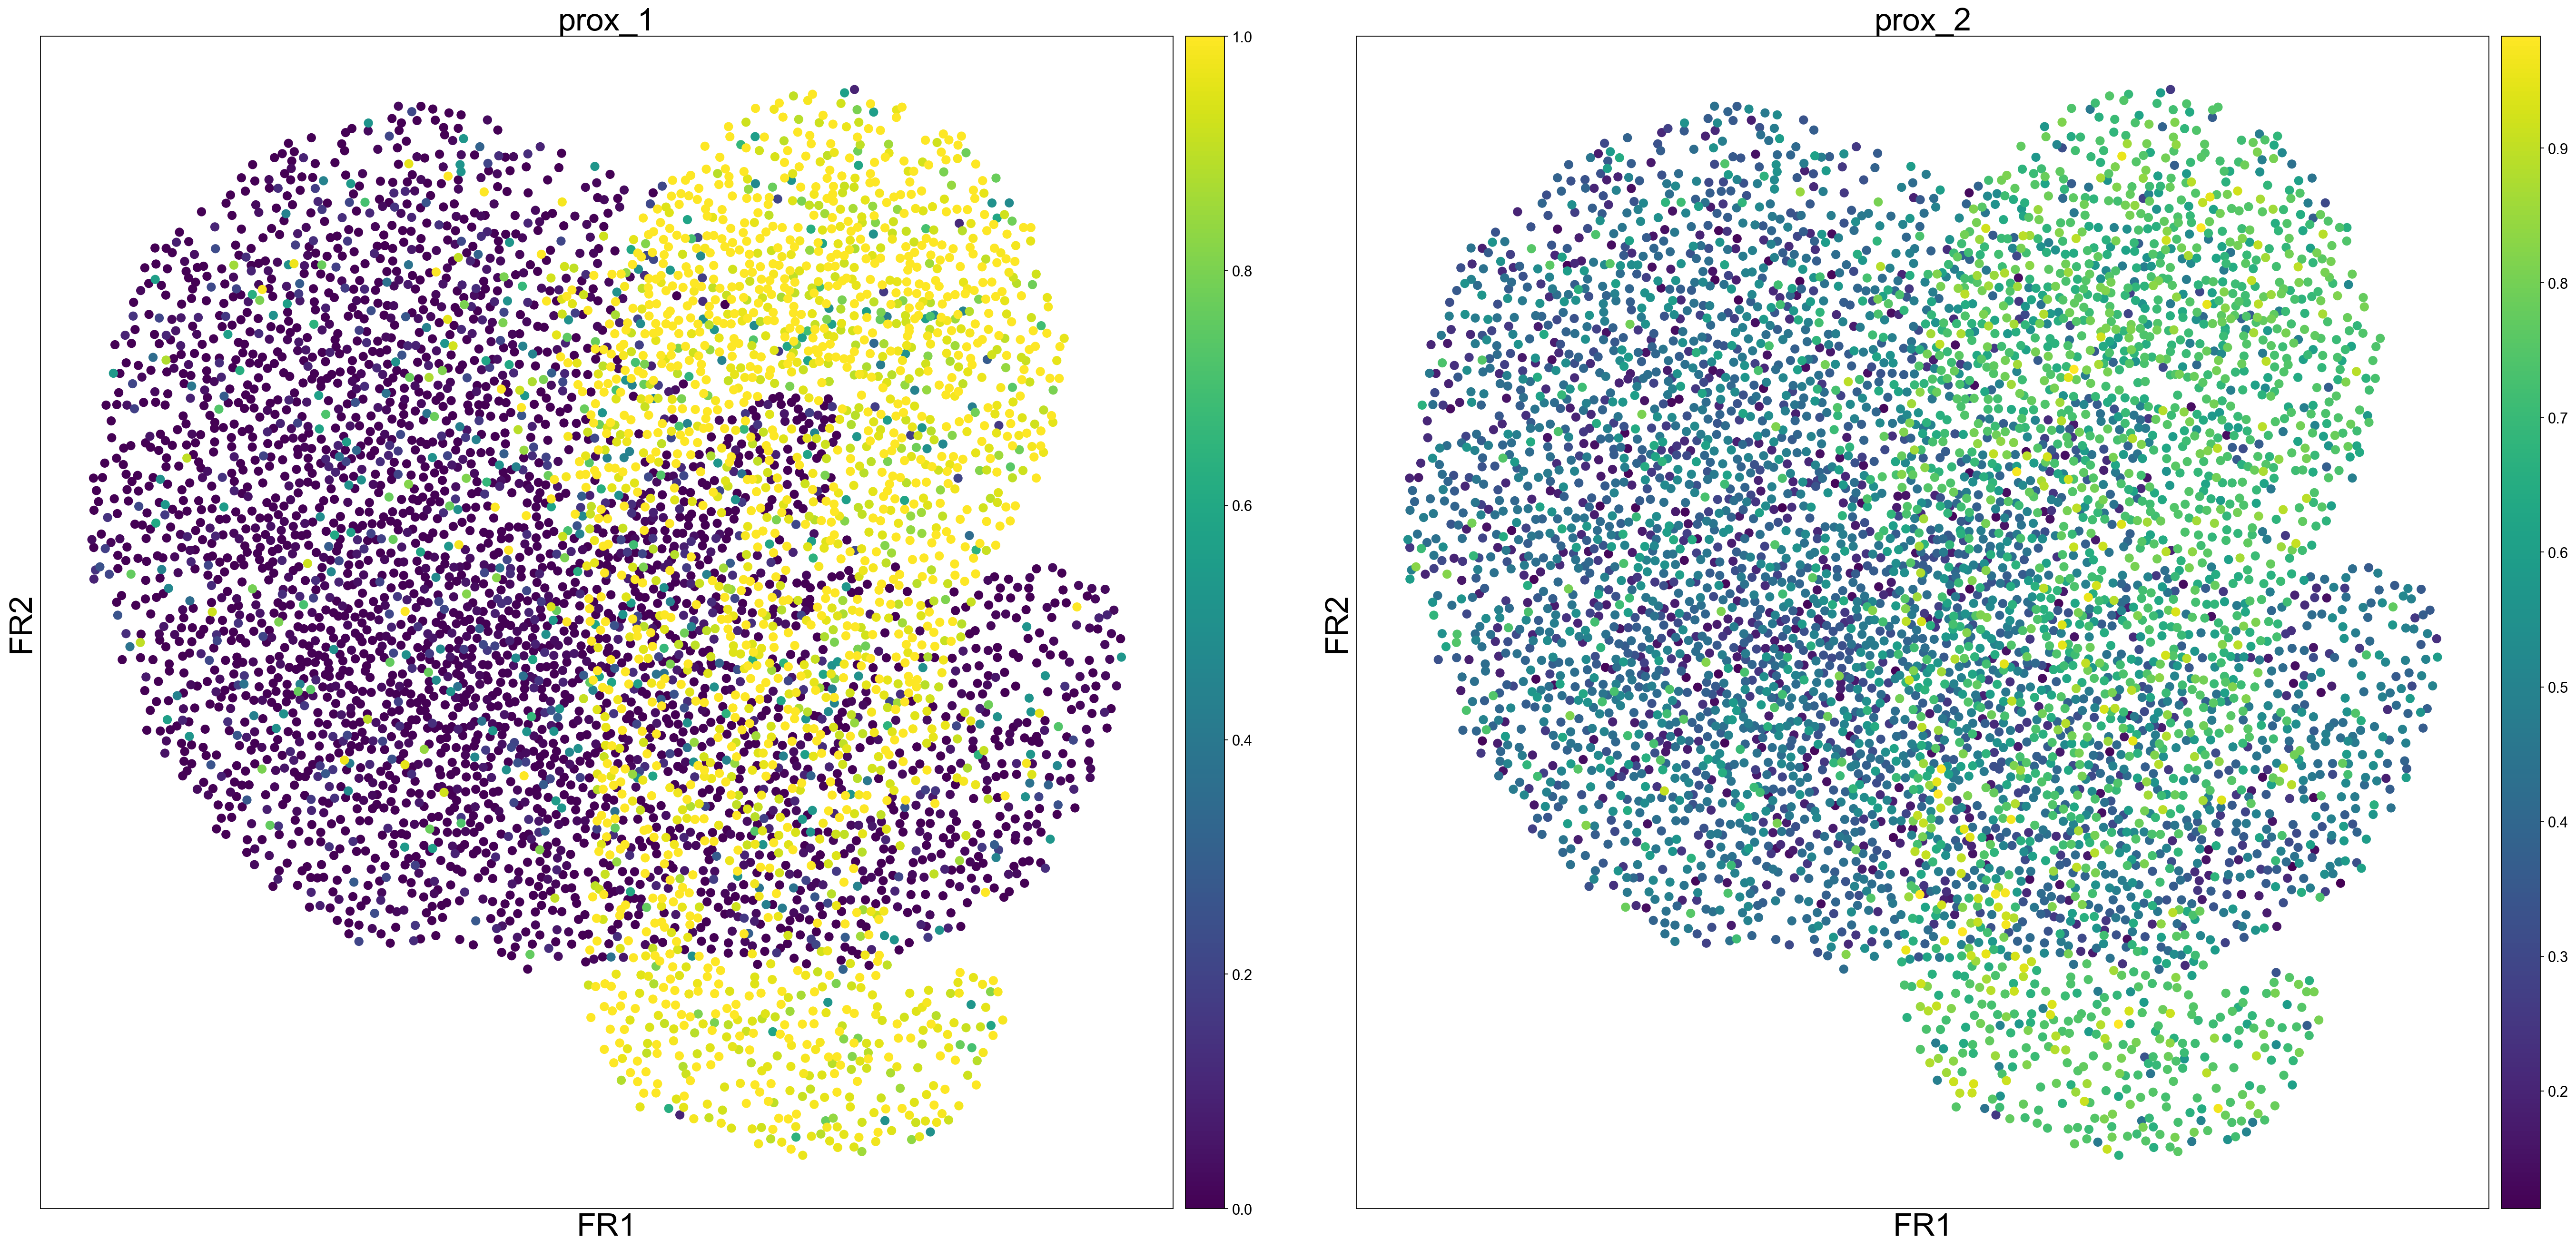

In [129]:
sc.pl.draw_graph(adata_m,
                 color=['prox_1','prox_2'],
                 legend_loc='on data',
                s=300)